<a href="https://colab.research.google.com/github/camilasp/customer_support_bot_router/blob/main/customer_support_bot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Customer Support Bot Router**

Nomes:

        Bruno Rodrigues

        Camila Polo

        Romão Martines

[Link do repositório no GitHub](https://github.com/camilasp/customer_support_bot_router)

## **1. Objetivo e Contexto**

O objetivo desse projeto é construir uma aplicação que consiga encaminhar um cliente que entra em contato com o serviço de suporte de uma empresa para o atendimento especializado.


Chatbots têm sido comumente usados por empresas para realizar uma parte do atendimento ao cliente ou até mesmo o atendimento completo em diversos casos. Esses bots são uma forma de gerar tanto economia quanto eficiência para uma empresa. Imagine um grande varejista que possui lojas online, por exemplo. Normalmente esse varejista possuirá diferentes setores, cada um relacionado com uma fase da compra (entrega, troca, reembolso, por exemplo). Cada um desses setores contará com especialistas naquela área específica de atuação. Nada mais natural que os responsáveis pelo atendimento sejam também especialistas numa determinada área, pois conseguirão resolver os problemas que surgirem com mais eficiência. Dessa forma, é interessante que as solicitações que envolvem essas diferentes fases de uma compra sejam encaminhadas para o setor correto.

Uma solução eficiente para esse problema, é criar um atendimento automático que sirva de entrada para todas as solicitações e saiba fazer o encaminhamento da demanda ao setor correto, de forma que o cliente inicie o chat com um robô e possa ser encaminhado a um chat com um atendente especializado, se necessário.

## **2. Base de dados**

A base de dados que será utilizada para treinar o modelo está disponível no [Kaggle](https://www.kaggle.com/datasets/536db59649ec509a2808c8d2c85d560c64e1dce44778a22ab79ce3408813e8fb). A base está em inglês e dessa forma só poderá classificar textos nessa língua.

O dataset contém cerca de 20000 registros/sentenças e a classificação da intenção destas sentenças. As categorias de intenção contidas no dataset foram selecionadas de forma que as escolhidas são aquelas que estão presentes em diferentes tipos de negócios. 

O dataset também possui uma coluna nomeada de "flags" que indicam as características de linguagem do registro, como polidez, uso de palavrões, formalidade, etc.

Lista de categorias e intenções contidas no dataset:

* ACCOUNT
* CANCELLATION_FEE
* CONTACT
* DELIVERY
* FEEDBACK
* INVOICES
* NEWSLETTER
* ORDER
* PAYMENT
* REFUNDS
* SHIPPING

Dentro dessas categorias, temos as seguintes intenções:

cancel_order

complaint

contact_customer_service

contact_human_agent

create_account

change_order

change_shipping_address

check_cancellation_fee

check_invoices

check_payment_methods

check_refund_policy

delete_account

delivery_options

delivery_period

edit_account

get_invoice

get_refund

newsletter_subscription

payment_issue

place_order

recover_password

registration_problems

review

set_up_shipping_address

switch_account

track_order

track_refund

O chatbot, ao receber uma solicitação contendo alguma das intenções categorizadas no dataset de treinamento deverá ser capaz de rotear a solicitação para o setor especializado.

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [58]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [201]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Projeto_NLP/chatbot_df.csv")

In [202]:
df

,flags,utterance,category,intent
0,BILC,"I don't have an online account, what do I have...",ACCOUNT,create_account
1,BILQZ,can you tell me if i can regisger two accounts...,ACCOUNT,create_account
2,BPLC,"I have no online account, open one, please",ACCOUNT,create_account
3,BIPLD,"could you ask an agent how to open an account,...",ACCOUNT,create_account
4,BLQC,"i want an online account, create one",ACCOUNT,create_account
...,...,...,...,...
21529,BILQC,"i have no shipping address, what do i have to ...",SHIPPING,set_up_shipping_address
21530,BLQC,I have no shipping address and I want to set o...,SHIPPING,set_up_shipping_address
21531,BIQC,"i want to set up my shipping address, what do ...",SHIPPING,set_up_shipping_address
21532,BILC,"I don't have a shipping address, can you set o...",SHIPPING,set_up_shipping_address


In [203]:
df.category.unique()

array(['ACCOUNT', 'CANCELLATION_FEE', 'CONTACT', 'DELIVERY', 'FEEDBACK',
       'INVOICES', 'NEWSLETTER', 'ORDER', 'PAYMENT', 'REFUNDS',
       'SHIPPING'], dtype=object)

In [204]:
categories = ['ACCOUNT', 'CANCELLATION_FEE', 'CONTACT', 'DELIVERY', 'FEEDBACK',
       'INVOICES', 'NEWSLETTER', 'ORDER', 'PAYMENT', 'REFUNDS',
       'SHIPPING']

## **3. Análise do conteúdo**

In [205]:
from wordcloud import WordCloud

In [206]:
all_words = ' '.join([text for text in df.utterance])

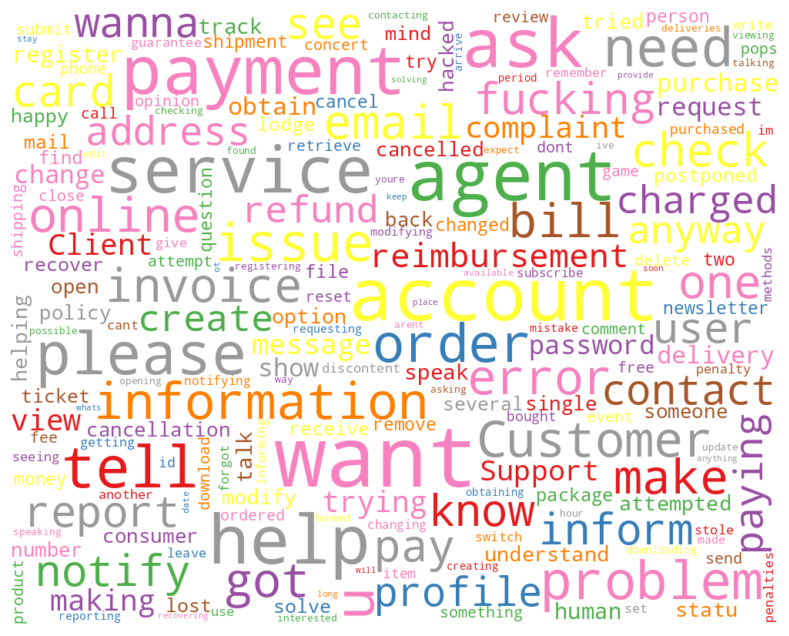

In [207]:
nuvem_palavras = WordCloud(width= 1000, height= 800, max_font_size = 110, background_color="white", colormap='Set1', collocations= False).generate(all_words)
plt.figure(figsize=(12,8))
plt.imshow(nuvem_palavras, interpolation='bilinear')
plt.axis("off")
plt.show()

Conseguimos perceber pela nuvem de palavras que temos no nosso corpus palavras com contrações ( "u", "dont", "cant"), maiúsculas e minúsculas, gírias e palavrões, palavras com spelling errado ("statu"), stopwords ("one", "in"). No próximo item tentaremos modificar e remover as palavras para deixar o corpus o mais informativo possível.

## **4. Limpeza e pré-processamento**

In [208]:
!pip install nltk
!pip install spacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [209]:
!python -m spacy download en

2023-05-28 20:35:13.048426: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 51.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


###**4.1 Lowercase**

Uma mesma palavra escrita com formatação de maiúsculas e minúsculas diferentes será entendida como sendo palavras diferentes. Dessa forma, iremos passar todos os caracteres das palavras do corpus para minúsculas.

In [210]:
def return_lowercase(text):
  return text.lower()

In [212]:
 df['lowercase'] = df['utterance'].str.lower()

###**4.2 Contrações**

Em inglês, contrações são muito comuns. Dessa forma, é interessante realizar a transformação dessas contrações antes de realizar a retirada de pontuação ou a tokenização das palavras, já que as contrações poderiam afetar ou impedir que essas tarefas sejam executadas corretamente.

In [213]:
CONTRACTION_MAP = {
    "ain't": "is not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "gonna": "going to",
    "gotta": "got to",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "im": "i am",
    "ive": "i have",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wanna": "want to",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have",
}

In [214]:
import re

def expand_contractions(text, contraction_map=CONTRACTION_MAP, lower=False):
    text_expanded = str(text)  # copy
    if lower:
        text_expanded = text_expanded.lower()
    
    for contraction, normal in contraction_map.items():
        text_expanded = re.sub(contraction, normal, text_expanded)
    
    return text_expanded

In [215]:
df['no_contract_utterance'] = df.apply(lambda row : expand_contractions(row['lowercase']), axis = 1)

###**4.3 Pontuação**

A pontuação também não é um elemento informativo para o nosso problema e para praticamente todos os problemas que envolvem NLP. Dessa forma, faremos a remoção dessa pontuação.

In [216]:
def remove_punctuation(text):
    regex = '[^\w\s]'
    
    return re.sub(regex, '', text)

In [217]:
 df['no_punctuation'] = df.apply(lambda row : remove_punctuation(row['no_contract_utterance']), axis = 1)

###**4.4 Stopwords**

Stopwords são aquelas palavras que não adicionam informação a um determinado contexto e portanto não é interessante utilizá-las na modelagem de um problema de NLP. 

Preposições, pronomes e verbos auxiliares são exemplos de palavras que em geral não trazem informações relevantes em diversos contexto. Num contexto de separação de textos em tópicos,  palavras que expressam sentimentos negativos como a palavra "não" ou palavrões, também podem ser consideradas stopwords, dependendo dos tópicos nos quais queremos dividir os textos. 

Nesse caso específico, temos um tópico com a categoria "complaint" que seria uma reclamação. Nesse caso, entendemos que palavras como "not" e mesmo palavrões podem ser importantes para sinalizar esse tópico e dessa forma serão mantidas no corpus.

In [74]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [218]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

Na lista de stopwords do NLTK, já temos algumas contractions incluídas que não precisariam ter sido modificadas na etapa 4.1.

In [219]:
stoplist = set(stopwords.words("english"))

In [220]:
len(stoplist)

179

In [221]:
#remove words that are in NLTK stopwords list
not_stopwords = {'not'} 
final_stopwords = set([word for word in stoplist if word not in not_stopwords])



In [222]:
len(final_stopwords)

178

In [223]:
def sentences_stopwords(lista):
  sentenca = ' '.join(lista)
  return sentenca

In [229]:
df['no_stopwords'] = df['no_punctuation'].apply(word_tokenize)
df['no_stopwords'] = df['no_stopwords'].apply(lambda words: [word for word in words if word not in final_stopwords ])
df['no_stopwords'] = df.apply(lambda row : sentences_stopwords(row['no_stopwords']), axis = 1)

###**4.5 Spelling**

In [26]:
pip install -U symspellpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 4.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for editdistpy: filename=editdistpy-0.1.3-cp310-cp310-linux_x86_64.whl size=141745 sha256=d743eabc66a6a0fd6f03f76523a378a811b1da295f1ed908750f7c9ddea417ab
  Stored in directory: /root/.cache/pip/wheels/88/6a/a6/a1283cc145323a1fb3d475bd158ee60b248ab1985230d266fc
Successfully built editdistpy


In [27]:
import pkg_resources
from symspellpy import SymSpell, Verbosity

sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt"

)


bigram_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_bigramdictionary_en_243_342.txt"
)
# term_index is the column of the term and count_index is the
# column of the term frequency
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)


sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
sym_spell.load_bigram_dictionary(bigram_path, term_index=0, count_index=2)



True

In [230]:
def correct_spelling(input):

  input_term = input

  suggestions = sym_spell.lookup_compound(input_term, max_edit_distance=2)


  return suggestions[0].term

In [231]:
from tqdm import tqdm
tqdm.pandas(desc='Progress')

In [232]:
df["spelling_correction"]= df.progress_apply(lambda row : correct_spelling(row['no_stopwords']), axis = 1)

Progress: 100%|██████████| 21534/21534 [00:19<00:00, 1105.46it/s]


In [233]:
df.head(5)

,flags,utterance,category,intent,lowercase,no_contract_utterance,no_punctuation,no_stopwords,spelling_correction
0,BILC,"I don't have an online account, what do I have...",ACCOUNT,create_account,"i don't have an online account, what do i have...","i do not have an online account, what do i hav...",i do not have an online account what do i have...,not online account register,not online account register
1,BILQZ,can you tell me if i can regisger two accounts...,ACCOUNT,create_account,can you tell me if i can regisger two accounts...,can you tell me if i can regisger two accounts...,can you tell me if i can regisger two accounts...,tell regisger two accounts single email address,tell register two accounts single email address
2,BPLC,"I have no online account, open one, please",ACCOUNT,create_account,"i have no online account, open one, please","i have no online account, open one, please",i have no online account open one please,online account open one please,online account open one please
3,BIPLD,"could you ask an agent how to open an account,...",ACCOUNT,create_account,"could you ask an agent how to open an account,...","could you ask an agent how to open an account,...",could you ask an agent how to open an account ...,could ask agent open account please,could ask agent open account please
4,BLQC,"i want an online account, create one",ACCOUNT,create_account,"i want an online account, create one","i want an online account, create one",i want an online account create one,want online account create one,want online account create one


###**4.6 Lemmatization**

Na lemmatization vamos buscar reduzir a palavra à sua raiz, retirando todas as inflexões e chegando ao lemma. Porém, diferentemente do stemming, essa redução sempre resultará em uma palavra que realmente existe na gramática. Outro ponto importante é que, nessa técnica, a classe gramatical da palavra será levada em consideração para fazer a redução. Dessa forma, escolhemos aplicar uma lemmatização no corpus.

In [234]:
import spacy
load_model = spacy.load('en_core_web_sm', disable = ['parser','ner'])

In [235]:
def apply_lemmatizer(lista):
  doc = load_model(lista)
  return " ".join([token.lemma_ for token in doc])
 

In [236]:
df['lemma']= df.apply(lambda row : apply_lemmatizer(row['spelling_correction']), axis = 1)

In [237]:
df.head(1)

,flags,utterance,category,intent,lowercase,no_contract_utterance,no_punctuation,no_stopwords,spelling_correction,lemma
0,BILC,"I don't have an online account, what do I have...",ACCOUNT,create_account,"i don't have an online account, what do i have...","i do not have an online account, what do i hav...",i do not have an online account what do i have...,not online account register,not online account register,not online account register


**Nuvem de palavras após pré-processamento do texto**

In [238]:
all_words = ' '.join([text for text in df.lemma])

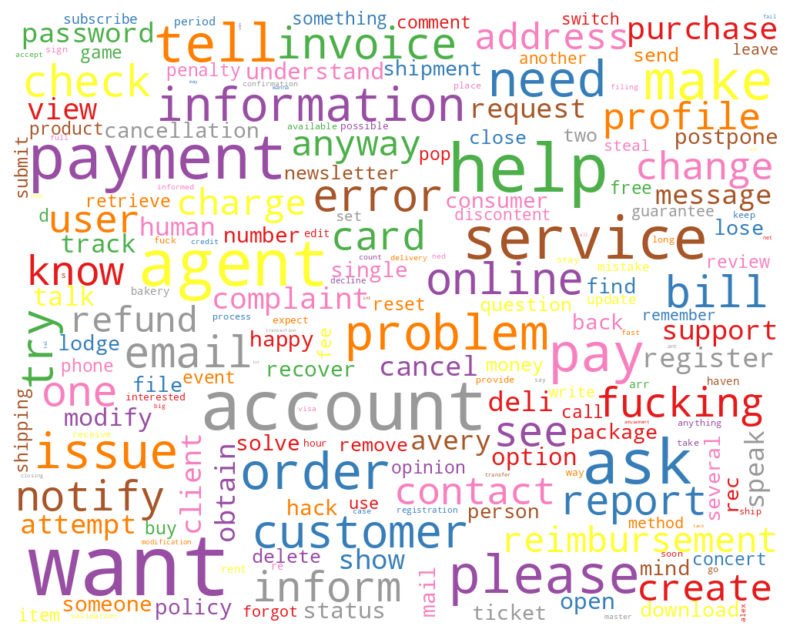

In [239]:
nuvem_palavras = WordCloud(width= 1000, height= 800, max_font_size = 110, background_color="white", colormap='Set1', collocations= False).generate(all_words)
plt.figure(figsize=(12,8))
plt.imshow(nuvem_palavras, interpolation='bilinear')
plt.axis("off")
plt.show()

## **5. Extração de características**


Utilizaremos a técnica de extração de características, TF-IDF.

In [240]:
from sklearn.model_selection import train_test_split

In [241]:
X = df[["spelling_correction", "lemma"]]
y = df.category.values

In [242]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.25)

**TF-IDF**

In [243]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [244]:
documents = X_train['lemma'].values

vectorizer = TfidfVectorizer(
    min_df=5,
    max_df=0.75,
    ngram_range=(1, 3),
    max_features=1000
).fit(documents)

vectorizer

TfidfVectorizer(max_df=0.75, max_features=1000, min_df=5, ngram_range=(1, 3))

In [245]:
X_train_ti = vectorizer.transform(documents)

In [246]:
X_test_ti = vectorizer.transform(X_test.lemma.values)

## **6. Classificadores**

In [320]:
df.category.value_counts(normalize=True)

PAYMENT             0.215287
ACCOUNT             0.211619
CONTACT             0.143076
INVOICES            0.113449
ORDER               0.104765
REFUNDS             0.089719
FEEDBACK            0.061577
DELIVERY            0.023266
CANCELLATION_FEE    0.016718
NEWSLETTER          0.010959
SHIPPING            0.009566
Name: category, dtype: float64

In [324]:
df[df['category'] == "FEEDBACK"]

,flags,utterance,category,intent,lowercase,no_contract_utterance,no_punctuation,no_stopwords,spelling_correction,lemma
8499,BLQD,ask an agent how i can make a consumer complai...,FEEDBACK,complaint,ask an agent how i can make a consumer complai...,ask an agent how i can make a consumer complai...,ask an agent how i can make a consumer complai...,ask agent make consumer complaint service,ask agent make consumer complaint service,ask agent make consumer complaint service
8500,BILC,"I want to submit a complaint, what do I have t...",FEEDBACK,complaint,"i want to submit a complaint, what do i have t...","i want to submit a complaint, what do i have t...",i want to submit a complaint what do i have to do,want submit complaint,want submit complaint,want submit complaint
8501,BILCZ,"I'm discontent with the service, how caj I sub...",FEEDBACK,complaint,"i'm discontent with the service, how caj i sub...","i am discontent with the service, how caj i su...",i am discontent with the service how caj i sub...,discontent service caj submit consumer complaint,discontent service can submit consumer complaint,discontent service can submit consumer complaint
8502,BLC,"I'm discontent with the service, file a complaint",FEEDBACK,complaint,"i'm discontent with the service, file a complaint","i am discontent with the service, file a compl...",i am discontent with the service file a complaint,discontent service file complaint,discontent service file complaint,discontent service file complaint
8503,BIPLDW,could you ask an agent how I can make a fuckin...,FEEDBACK,complaint,could you ask an agent how i can make a fuckin...,could you ask an agent how i can make a fuckin...,could you ask an agent how i can make a fuckin...,could ask agent make fucking complaint please,could ask agent make fucking complaint please,could ask agent make fucking complaint please
...,...,...,...,...,...,...,...,...,...,...
9820,BILCZ,"I'm hqppy with the service, what should I do t...",FEEDBACK,review,"i'm hqppy with the service, what should i do t...","i am hqppy with the service, what should i do ...",i am hqppy with the service what should i do t...,hqppy service make opinion,happy service make opinion,happy service make opinion
9821,BILC,"I'm happy with the service, what should I do t...",FEEDBACK,review,"i'm happy with the service, what should i do t...","i am happy with the service, what should i do ...",i am happy with the service what should i do t...,happy service file opinion,happy service file opinion,happy service file opinion
9822,BIPLQD,can u ask an agent if i could write a comment?,FEEDBACK,review,can u ask an agent if i could write a comment?,can u ask an agent if i could write a comment?,can u ask an agent if i could write a comment,u ask agent could write comment,a ask agent could write comment,a ask agent could write comment
9823,BILQD,can u ask an agent how i can leave an opinion ...,FEEDBACK,review,can u ask an agent how i can leave an opinion ...,can u ask an agent how i can leave an opinion ...,can u ask an agent how i can leave an opinion ...,u ask agent leave opinion service,a ask agent leave opinion service,a ask agent leave opinion service


**Naive Bayes**

In [248]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline

In [249]:
NB_classifier = OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))
            

In [250]:
NB_classifier.fit(X_train_ti, y_train)
y_pred = NB_classifier.predict(X_test_ti)
    

In [251]:
from sklearn.metrics import classification_report

In [252]:
print(classification_report(y_test, y_pred))

                  precision    recall  f1-score   support

         ACCOUNT       1.00      0.99      0.99      1139
CANCELLATION_FEE       1.00      1.00      1.00        90
         CONTACT       1.00      1.00      1.00       770
        DELIVERY       0.96      0.99      0.98       125
        FEEDBACK       1.00      1.00      1.00       332
        INVOICES       1.00      1.00      1.00       611
      NEWSLETTER       1.00      0.98      0.99        59
           ORDER       0.99      0.98      0.99       564
         PAYMENT       0.99      1.00      0.99      1159
         REFUNDS       1.00      1.00      1.00       483
        SHIPPING       1.00      0.98      0.99        52

        accuracy                           0.99      5384
       macro avg       0.99      0.99      0.99      5384
    weighted avg       0.99      0.99      0.99      5384



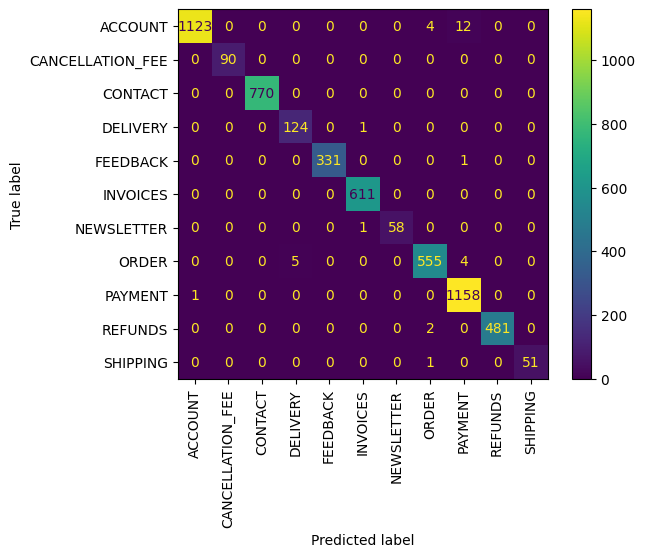

In [253]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=sorted(df.category.unique()))

cmd.plot()

plt.xticks(rotation=90)
plt.show()

**O modelo Naive Bayes apresentou uma excelente performance, mesmo sem a realização da otimização de hiperparâmetros.Vamos deixá-lo assim por enquanto e vamos testar mais um modelo de classificação, no caso, uma regressão logística.**

**Logistic Regression**

In [254]:
from sklearn.linear_model import LogisticRegression

In [255]:
classifier = LogisticRegression(
    multi_class='ovr',
    solver='lbfgs',
    class_weight='balanced',
    random_state=42
).fit(X_train_ti, y_train)

In [256]:
y_pred=classifier.predict(X_test_ti)

In [257]:
print(classification_report(y_test, y_pred))

                  precision    recall  f1-score   support

         ACCOUNT       1.00      0.99      1.00      1139
CANCELLATION_FEE       1.00      1.00      1.00        90
         CONTACT       1.00      1.00      1.00       770
        DELIVERY       0.99      1.00      1.00       125
        FEEDBACK       1.00      1.00      1.00       332
        INVOICES       1.00      1.00      1.00       611
      NEWSLETTER       1.00      1.00      1.00        59
           ORDER       1.00      1.00      1.00       564
         PAYMENT       0.99      1.00      1.00      1159
         REFUNDS       1.00      1.00      1.00       483
        SHIPPING       1.00      0.98      0.99        52

        accuracy                           1.00      5384
       macro avg       1.00      1.00      1.00      5384
    weighted avg       1.00      1.00      1.00      5384



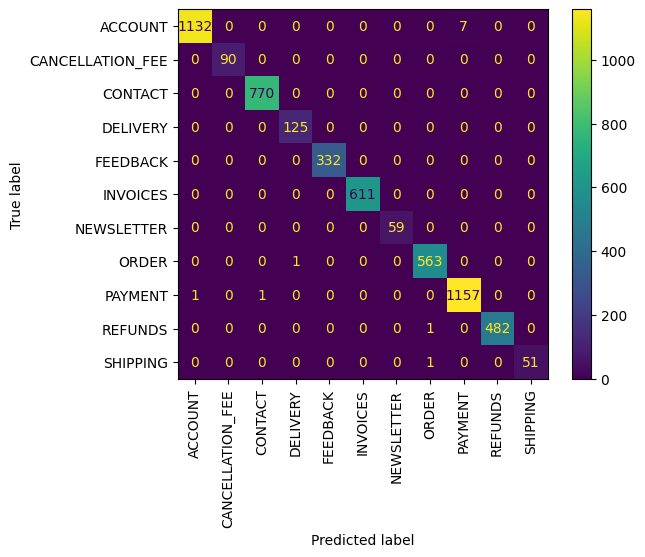

In [258]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=sorted(df.category.unique()))

cmd.plot()

plt.xticks(rotation=90)
plt.show()

A Regressão Logística trouxe excelentes resultados também. Como os dois modelos testados não são modelos tão poderosos, ainda mais considerando que não foi feita otimização de hiperparâmetros e mesmo assim obtivemos quase 100% de acerto em todas as categorias, os resultados se tornam suspeitos. Como não houve vazamento de dados - tanto o vetorizador quanto os modelos foram treinados apenas no conjunto de treino - nossa hipótese é de que as frases trazidas para cada tópico devem conter muitas palavras em comum entre si dentro de um tópico, o que facilita sua classificação. 

Na etapa de Experimetação e validação essa hipótese será testada.

##**7. Protocolos de Experimento e Validação**

Para validar nossos resultados, seria interessante testarmos nosso classificador contra amostras out of sample e out of time. Como o dataset de treinamento não é um dataset real, essas amostras não existem e por isso não podem ser coletadas. Não faz sentido criarmos uma amostra out of time, mas uma amostra out of sample pode ser criada e nos ajudará a averiguar a performance do modelo sobre dados diferentes daqueles do dataset.

Poderíamos tentar encontrar um dataset com uma proposta similar a este, mas a abordagem que será utilizada será a criação de um dataset com dados sintéticos. Para isso, solicitamos ao Chat GPT que criasse frases ou questões relacionadas aos temas dos tópicos presentes no dataset, tentando utilizar sinônimos e não as próprias palavras que dão nome aos tópicos (o intuito aqui é dificultar o serviço do classificador, apresentando um vocabulário diferente e assim validar nossa hipótese sobre os resultados excelentes obtidos).

Abaixo a criação do dataset com as frases sintéticas, para cada tópico, dez frases foram criadas:

In [308]:
val_data = {'phrase': ["How can I create a new user profile?",
"Can I modify the email address linked to my account?",
"What should I do if I forget my login credentials?",
"How do I update my personal details on my profile?",
"Am I allowed to have multiple accounts using the same email?",
"Is my account information kept secure?",
"Can I delete my user profile?",
"How can I adjust the settings on my account?",
"Is it possible to merge two separate user profiles?",
"What advantages do I get by setting up an account?",
 "What is the cost associated with canceling my order?",
"How can I avoid paying a fee for cancellation?",
"Is there a time limit to cancel an order without incurring charges?",
"Can I receive a refund for the cancellation fee if I change my mind?",
"Why is there a penalty for canceling an order?",
"Are there any exceptions where the cancellation fee is waived?", 
"How can I calculate the fee for canceling my specific order?",
"Can I negotiate or reduce the cancellation charge?",
"What happens if I cancel my subscription before the contract ends?",
"Is the fee different for different types of products or services?",
"How can I get in touch with your customer support team?",
"What are your available communication hours?",
"Is there a specific helpline for urgent inquiries?",
"Can I reach out via email or chat for non-urgent matters?",
"What is the typical response time from your customer service?",
"Do you have specialized support for technical issues?",
"Is there a separate contact point for international customers?",
"Can I schedule a call back from your customer service team?",
"What information should I provide when contacting your support?",
"Is there a charge for customer service inquiries?",
"How long does it take for my order to reach me?",
"Can I track the status of my package?",
"Which shipping providers do you use for deliveries?",
"Do you offer expedited or express shipping options?",
"Is there a shipping fee? If yes, what is the cost?",
"Can I update the delivery address after placing the order?",
"What should I do if my delivery doesn't arrive within the estimated timeframe?",
"Do you offer international shipment services?",
"Can I request a specific delivery date or time slot?",
"What happens if I'm unavailable to receive the package?",
"I wanted to express my appreciation for the excellent customer service I received.",
"I'm extremely satisfied with the prompt resolution of my issue.",
"The product exceeded my expectations, and I'm delighted with my purchase.",
"I would like to provide feedback on the user-friendliness of your website.",
"The delivery was delayed, and I would appreciate updates on the status in the future.",
"I had a negative experience with one of your representatives who was unhelpful.",
"The packaging of the product was damaged upon arrival, and I wanted to report it.",
"I believe there is room for improvement in the product's functionality.",
"The pricing of your services seems high compared to your competitors.",
"I'm dissatisfied with the quality of the product and would like a refund.",
"How can I access the documentation for my previous transactions?",
"Can you resend a copy of my financial records?",
"Are the invoices available in a digital format?",
"Can I request a specific format or additional details on the financial document?",
"Do the invoices include taxes and charges?",
"What payment methods are accepted for invoice settlement?",
"Can I set up automatic payments for recurring invoices?",
"Are there any penalties for late payment of invoices?",
"Can I dispute an item or charge mentioned in the invoice?",
"How long do you retain the invoice records?", 
"How can I subscribe to your regular updates?",
"Can I select the specific topics or categories I'm interested in?",
"Do you send the newsletter via email or is it available on your website?",
"How frequently do you send out newsletters?",
"Can I unsubscribe from the mailing list at any time?",
"Will my personal information be shared with third parties when I subscribe?",
"Can I customize the frequency of newsletter delivery?",
"Are there any exclusive offers or discounts for newsletter subscribers?",
"Can I share the newsletter with friends or colleagues?",
"How can I provide feedback or suggestions for newsletter content?",
"How do I place a purchase on your website?", 
"Can I make modifications to my order once it's placed?", 
"Am I able to cancel my order before it's shipped?", 
"What information do I need to provide while placing an order?", 
"Can I order products that are out of stock?", 
"Can I place an order by phone or email instead of using the website?", 
"Can I add a gift message or special instructions to my order?", 
"How will I know if my order has been successfully placed?", 
"Can I place a bulk order for a larger quantity of items?",
"Can I change my mind after placing an order and switch to a different product?",
"What forms of payment do you accept?",
"Is my credit card information secure during the payment process?",
"Can I split my payment between multiple methods for a single order?",
"Are there any additional charges for specific payment methods?",
"Can I save my payment details for future orders?",
"Can I use a prepaid gift card for payment?",
"Can I opt for installment payments or a payment plan?",
"How long does it take for the payment to be processed?",
"Can I get a refund if I accidentally overpay?",
"What should I do if my payment is declined?",
"What is your policy regarding reimbursements?",
"How long does it take to receive a refund?", 
"Can I receive a refund for returned items?",
"Is there a restocking fee for product returns?",
"Can I get a refund if my order arrives damaged?",
"Do I need to return the item in its original packaging for a refund?",
"Can I get a refund if the price of the item decreases after my purchase?",
"What is the process for requesting a refund?",
"Can I exchange the item instead of getting a refund?",
"Are there any exceptions or limitations to the refund policy?",
"What are your shipping methods and rates?",
"Can I track the progress of my shipment?",
"Which courier services do you use for deliveries?",
"Can I request a specific shipping option or speed?",
"Do you offer complimentary shipping?",
"Can I update the shipping address after placing the order?",
"Can I ship to a different country than my billing address?",
"How long does it usually take for the shipment to arrive?",
"Can I request a signature upon delivery?",
"What happens if my shipment is lost or damaged in transit?"
],
'label': ["ACCOUNT", "ACCOUNT", "ACCOUNT", "ACCOUNT", 
          "ACCOUNT", "ACCOUNT", "ACCOUNT", "ACCOUNT", "ACCOUNT", "ACCOUNT", 
          "CANCELLATION_FEE", "CANCELLATION_FEE", "CANCELLATION_FEE", "CANCELLATION_FEE", "CANCELLATION_FEE",
          "CANCELLATION_FEE", "CANCELLATION_FEE", "CANCELLATION_FEE", "CANCELLATION_FEE", "CANCELLATION_FEE",
          "CONTACT", "CONTACT", "CONTACT", "CONTACT", "CONTACT", "CONTACT", "CONTACT", "CONTACT", "CONTACT", "CONTACT",
          "DELIVERY", "DELIVERY", "DELIVERY", "DELIVERY", "DELIVERY", 
          "DELIVERY", "DELIVERY", "DELIVERY", "DELIVERY", "DELIVERY",
          "FEEDBACK", "FEEDBACK", "FEEDBACK", "FEEDBACK", "FEEDBACK", 
          "FEEDBACK", "FEEDBACK", "FEEDBACK", "FEEDBACK", "FEEDBACK",
          "INVOICES","INVOICES","INVOICES","INVOICES","INVOICES","INVOICES","INVOICES","INVOICES","INVOICES","INVOICES",
          "NEWSLETTER", "NEWSLETTER", "NEWSLETTER", "NEWSLETTER", "NEWSLETTER",
          "NEWSLETTER", "NEWSLETTER", "NEWSLETTER", "NEWSLETTER", "NEWSLETTER",
          "ORDER", "ORDER", "ORDER", "ORDER", "ORDER","ORDER", "ORDER", "ORDER", "ORDER", "ORDER",
          "PAYMENT", "PAYMENT", "PAYMENT", "PAYMENT", "PAYMENT",
          "PAYMENT", "PAYMENT", "PAYMENT", "PAYMENT", "PAYMENT",
          "REFUNDS", "REFUNDS", "REFUNDS", "REFUNDS", "REFUNDS", "REFUNDS", "REFUNDS", "REFUNDS", "REFUNDS", "REFUNDS",
          "SHIPPING", "SHIPPING", "SHIPPING", "SHIPPING", "SHIPPING",
          "SHIPPING", "SHIPPING", "SHIPPING", "SHIPPING", "SHIPPING"          
          ]}


oos_set = pd.DataFrame(data=val_data)

In [309]:
oos_set

,phrase,label
0,How can I create a new user profile?,ACCOUNT
1,Can I modify the email address linked to my ac...,ACCOUNT
2,What should I do if I forget my login credenti...,ACCOUNT
3,How do I update my personal details on my prof...,ACCOUNT
4,Am I allowed to have multiple accounts using t...,ACCOUNT
...,...,...
105,Can I update the shipping address after placin...,SHIPPING
106,Can I ship to a different country than my bill...,SHIPPING
107,How long does it usually take for the shipment...,SHIPPING
108,Can I request a signature upon delivery?,SHIPPING


**Agora vamos processar nosso texto para que ele possa ser classificado:**

In [310]:
 oos_set['lowercase'] = oos_set['phrase'].str.lower()

In [311]:
oos_set['no_contract_utterance'] = oos_set.apply(lambda row : expand_contractions(row['lowercase']), axis = 1)

In [312]:
oos_set['no_punctuation'] = oos_set.apply(lambda row : remove_punctuation(row['no_contract_utterance']), axis = 1)

In [313]:
oos_set['no_stopwords'] = oos_set['no_punctuation'].apply(word_tokenize)
oos_set['no_stopwords'] = oos_set['no_stopwords'].apply(lambda words: [word for word in words if word not in final_stopwords ])
oos_set['no_stopwords'] = oos_set.apply(lambda row : sentences_stopwords(row['no_stopwords']), axis = 1)

In [314]:
oos_set["spelling_correction"]= oos_set.apply(lambda row : correct_spelling(row['no_stopwords']), axis = 1)

In [315]:
oos_set['lemma']= oos_set.apply(lambda row : apply_lemmatizer(row['spelling_correction']), axis = 1)

In [316]:
oos_set.head()

,phrase,label,lowercase,no_contract_utterance,no_punctuation,no_stopwords,spelling_correction,lemma
0,How can I create a new user profile?,ACCOUNT,how can i create a new user profile?,how can i create a new user profile?,how can i create a new user profile,create new user profile,create new user profile,create new user profile
1,Can I modify the email address linked to my ac...,ACCOUNT,can i modify the email address linked to my ac...,can i modify the email address linked to my ac...,can i modify the email address linked to my ac...,modify email address linked account,modify email address linked account,modify email address link account
2,What should I do if I forget my login credenti...,ACCOUNT,what should i do if i forget my login credenti...,what should i do if i forget my login credenti...,what should i do if i forget my login credentials,forget login credentials,forget login credentials,forget login credential
3,How do I update my personal details on my prof...,ACCOUNT,how do i update my personal details on my prof...,how do i update my personal details on my prof...,how do i update my personal details on my profile,update personal details profile,update personal details profile,update personal detail profile
4,Am I allowed to have multiple accounts using t...,ACCOUNT,am i allowed to have multiple accounts using t...,am i allowed to have multiple accounts using t...,am i allowed to have multiple accounts using t...,allowed multiple accounts using email,allowed multiple accounts using email,allow multiple account use email


In [317]:
#TF-IDF
X_oos_set = vectorizer.transform(oos_set.lemma.values)

In [318]:
#Naive Bayes
y_pred_oos = NB_classifier.predict(X_oos_set)

In [319]:
print(classification_report(oos_set.label.values, y_pred_oos))

                  precision    recall  f1-score   support

         ACCOUNT       0.64      0.90      0.75        10
CANCELLATION_FEE       0.86      0.60      0.71        10
         CONTACT       0.64      0.70      0.67        10
        DELIVERY       0.60      0.30      0.40        10
        FEEDBACK       0.00      0.00      0.00        10
        INVOICES       1.00      0.40      0.57        10
      NEWSLETTER       1.00      0.70      0.82        10
           ORDER       0.23      0.50      0.31        10
         PAYMENT       0.41      0.90      0.56        10
         REFUNDS       0.82      0.90      0.86        10
        SHIPPING       0.57      0.40      0.47        10

        accuracy                           0.57       110
       macro avg       0.61      0.57      0.56       110
    weighted avg       0.61      0.57      0.56       110



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [325]:
#Logistic Regression
y_pred_oos_lr =classifier.predict(X_oos_set)

In [326]:
print(classification_report(oos_set.label.values, y_pred_oos_lr))

                  precision    recall  f1-score   support

         ACCOUNT       0.56      1.00      0.71        10
CANCELLATION_FEE       1.00      0.40      0.57        10
         CONTACT       0.80      0.80      0.80        10
        DELIVERY       0.60      0.30      0.40        10
        FEEDBACK       0.00      0.00      0.00        10
        INVOICES       1.00      0.70      0.82        10
      NEWSLETTER       1.00      0.80      0.89        10
           ORDER       0.37      1.00      0.54        10
         PAYMENT       0.75      0.90      0.82        10
         REFUNDS       0.71      1.00      0.83        10
        SHIPPING       0.80      0.40      0.53        10

        accuracy                           0.66       110
       macro avg       0.69      0.66      0.63       110
    weighted avg       0.69      0.66      0.63       110



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##**8. Conclusão e trabalhos futuros**

Conforme suspeitávamos, a performance de ambos os classificadores foi muito inferior para nosso dataset out of sample. Isso reforça nossa tese de que, no dataset original, as frases de cada tópico dividem muitas palavras comuns entre si dentro de seus tópicos, tornando a classificação mais assertiva. Pode ser que a palavra que nomeia o tópico também esteja presente na maioria das frases. 

Nesse contexto, considerando que os classificadores obtiveram desempenho máximo para o dataset de treino escolhido para elaborar o problema, não faz sentido mexer nesses classificadores. Para trabalhos futuros, o ideal seria usar outra fonte de dados ou incrementar essa fonte com mais dados, aumentando assim o corpus e a diferenciação de vocabulário dentro dos tópicos e por consequencia, permitindo que o modelo aprendesse mais padrões.

## Criação da pipeline para a aplicação

In [266]:
def compose (*functions):
    def inner(arg):
        for f in reversed(functions):
            arg = f(arg)
        return arg
    return inner


In [275]:
composed = compose(correct_spelling, remove_punctuation, expand_contractions, return_lowercase)

In [276]:
composed("I'd like to get a refund")

'i would like to get a refund'